In [11]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from scipy.optimize import curve_fit
import xarray as xr
from global_land_mask import globe
import cartopy.crs as ccrs
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [3]:
#a = '/media/rakshith/Seagate Expansion Drive/mraks/ERA Prec, Pwat all region.nc'
#a = '/media/rakshith/Seagate Expansion Drive/mraks/TGMS ERA 1959-2021, India only.nc'
a = '/media/rakshith/Windows/Users/mraks/TGMS ERA 1959-2021, India only.nc'
ds = xr.open_dataset(a)

In [4]:
region = str(input('Enter the region for comparision\n I=India, BOB=Bay of Bengal, EIO=Equitorial Indian Ocean\n'))
                   
if region=='I':
        lat1, lat2, lon1, lon2 = 30, 10, 70, 90
        region='India'
        str1='-'
elif region=='BOB':
        lat1, lat2, lon1, lon2 = 20, 10, 85, 95
        region='Bay of Bengal'
        str1='-'
elif region=='EIO':
        lat1, lat2, lon1, lon2 = 5, -5, 90, 100
        region='Equitorial Indian Ocean'
        str1='S-'
else:
    print('Please enter proper code')

Enter the region for comparision
 I=India, BOB=Bay of Bengal, EIO=Equitorial Indian Ocean
I


In [26]:
#For JJAS
jjas = ds.time.dt.month.isin(range(6, 10))
clim = ds.sel(time=jjas) #ds with only JJAS months

#For all months
#clim=ds
clim2 = clim.sel(latitude=slice(lat1,lat2), longitude=slice(lon1,lon2))

In [27]:
year1='1959'
year2='1968'
year3='2012'
year4='2021'
grid1 = clim2.sel(time=slice(year1, year2))
grid2 = clim2.sel(time=slice(year3, year4))
    
l=[]
for i in grid1.longitude:
    if i>180:
        l.append(i-360)
    else:
        l.append(i)
            
lon_grid, lat_grid = np.meshgrid(l, grid1.latitude)
mask = globe.is_land(lat_grid, lon_grid)

In [28]:
if region=='India':
    grid1 = grid1.where(mask>0).mean(dim=['latitude', 'longitude']).squeeze()
    grid2 = grid2.where(mask>0).mean(dim=['latitude', 'longitude']).squeeze()
    Pwat1 = grid1.tcwv
    Pr1 = 86400*28.96*(grid1.mtpr+grid1.mer)
    Qnet1 = grid1.mtnswrf + grid1.mtnlwrf
    Pwat2 = grid2.tcwv
    Pr2 = 86400*28.96*(grid2.mtpr+grid2.mer)
    Qnet2 = grid2.mtnswrf + grid2.mtnlwrf
else:
    Pwat1 = grid1.tcwv.where(mask==0).mean(dim=['latitude', 'longitude']).squeeze()
    Pr1 = 86400*grid1.mtpr.where(mask==0).mean(dim=['latitude', 'longitude']).squeeze()
    Pwat2 = grid2.tcwv.where(mask==0).mean(dim=['latitude', 'longitude']).squeeze()
    Pr2 = 86400*grid2.mtpr.where(mask==0).mean(dim=['latitude', 'longitude']).squeeze()

In [29]:
ratio1 = np.divide(Pr1, Qnet1)
ratio2 = np.divide(Pr2, Qnet2)

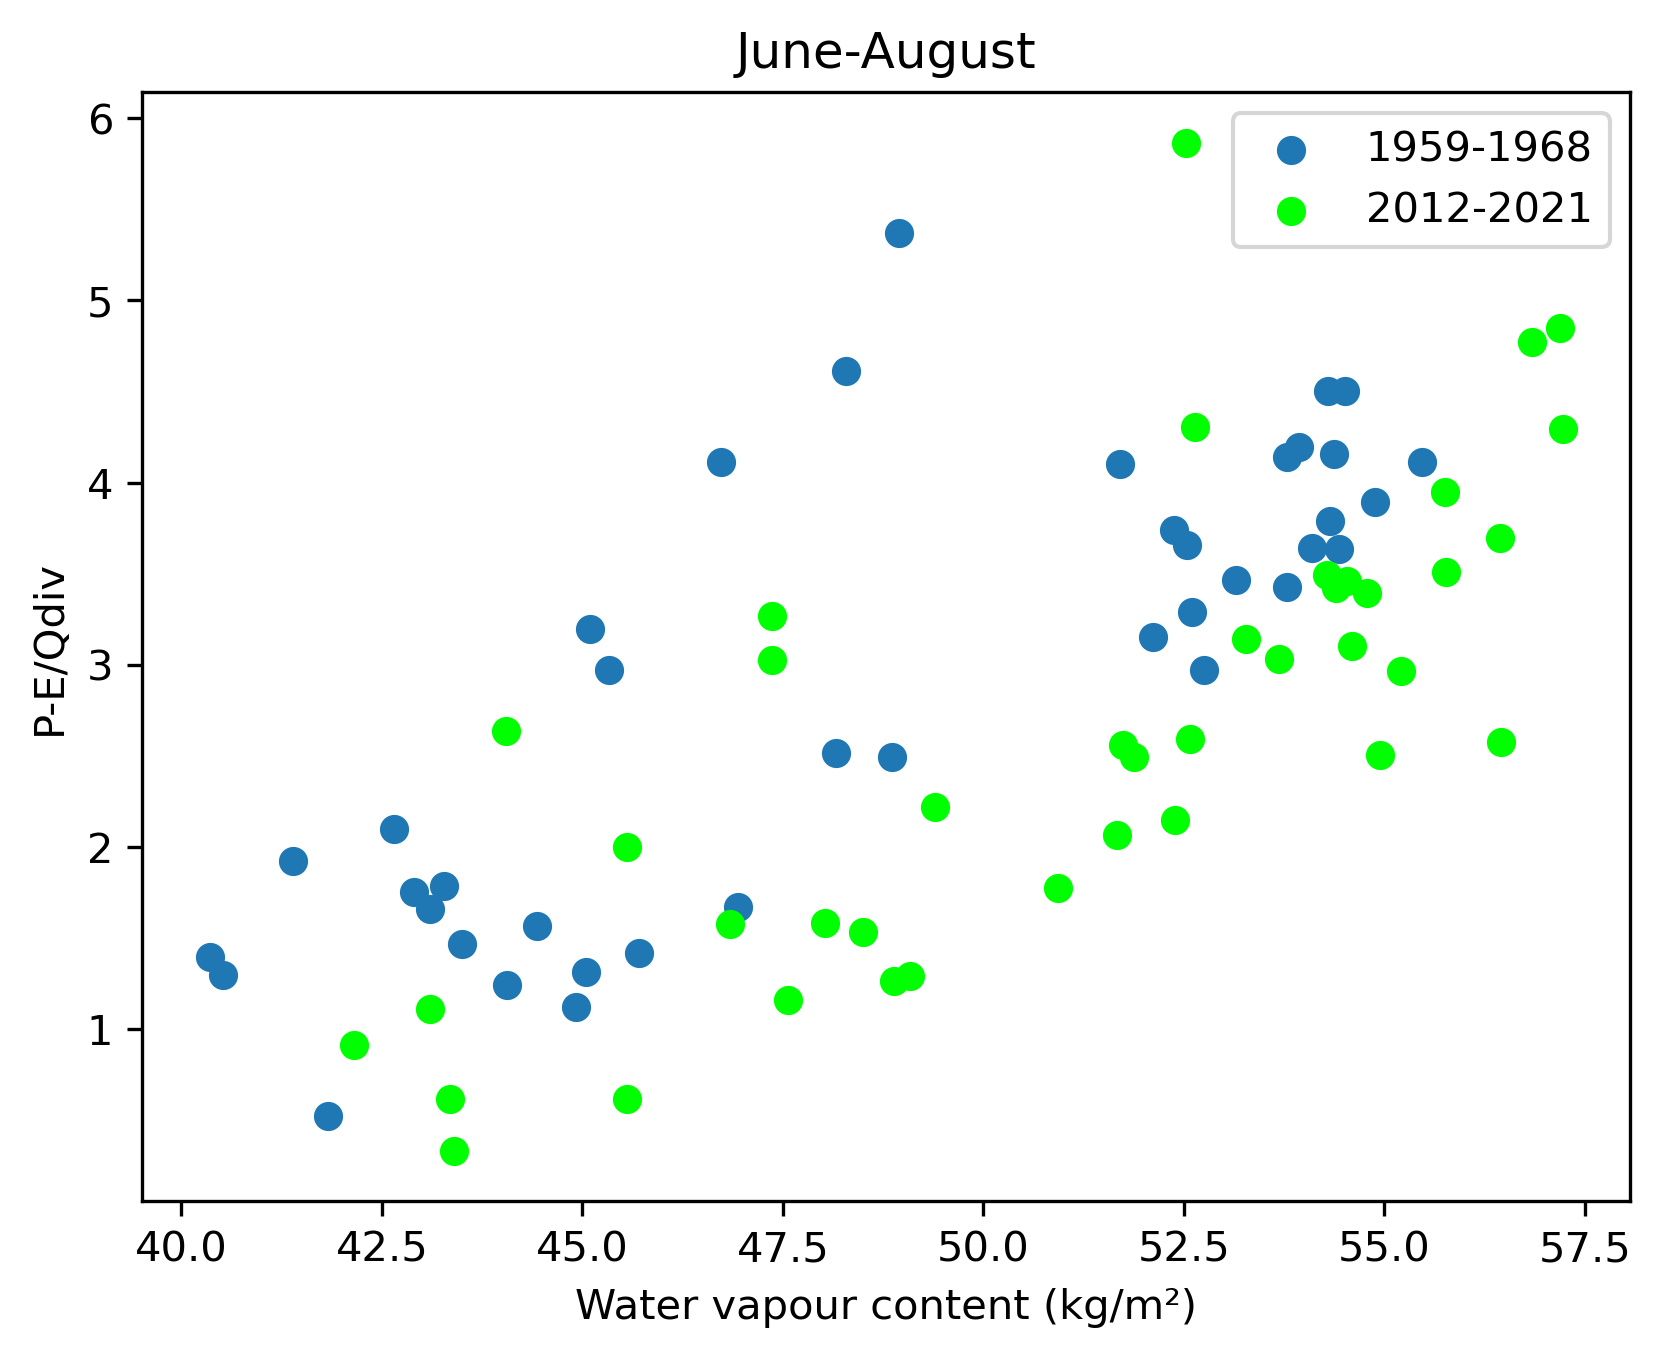

In [30]:
plt.scatter(Pwat1, ratio1, label=year1 + '-' + year2)
plt.scatter(Pwat2, ratio2, label=year3 + '-' + year4, c='lime')
plt.xlabel('Water vapour content (kg/m\u00b2)')
plt.ylabel('P-E/Qdiv')
#plt.title('ERA5, region: '+ region + " ({}".format(abs(lat2)) + str1 +"{}N, {}-{}E) ".format(abs(lat1), abs(lon1), abs(lon2)))
plt.title('June-August')
plt.legend()
plt.show()

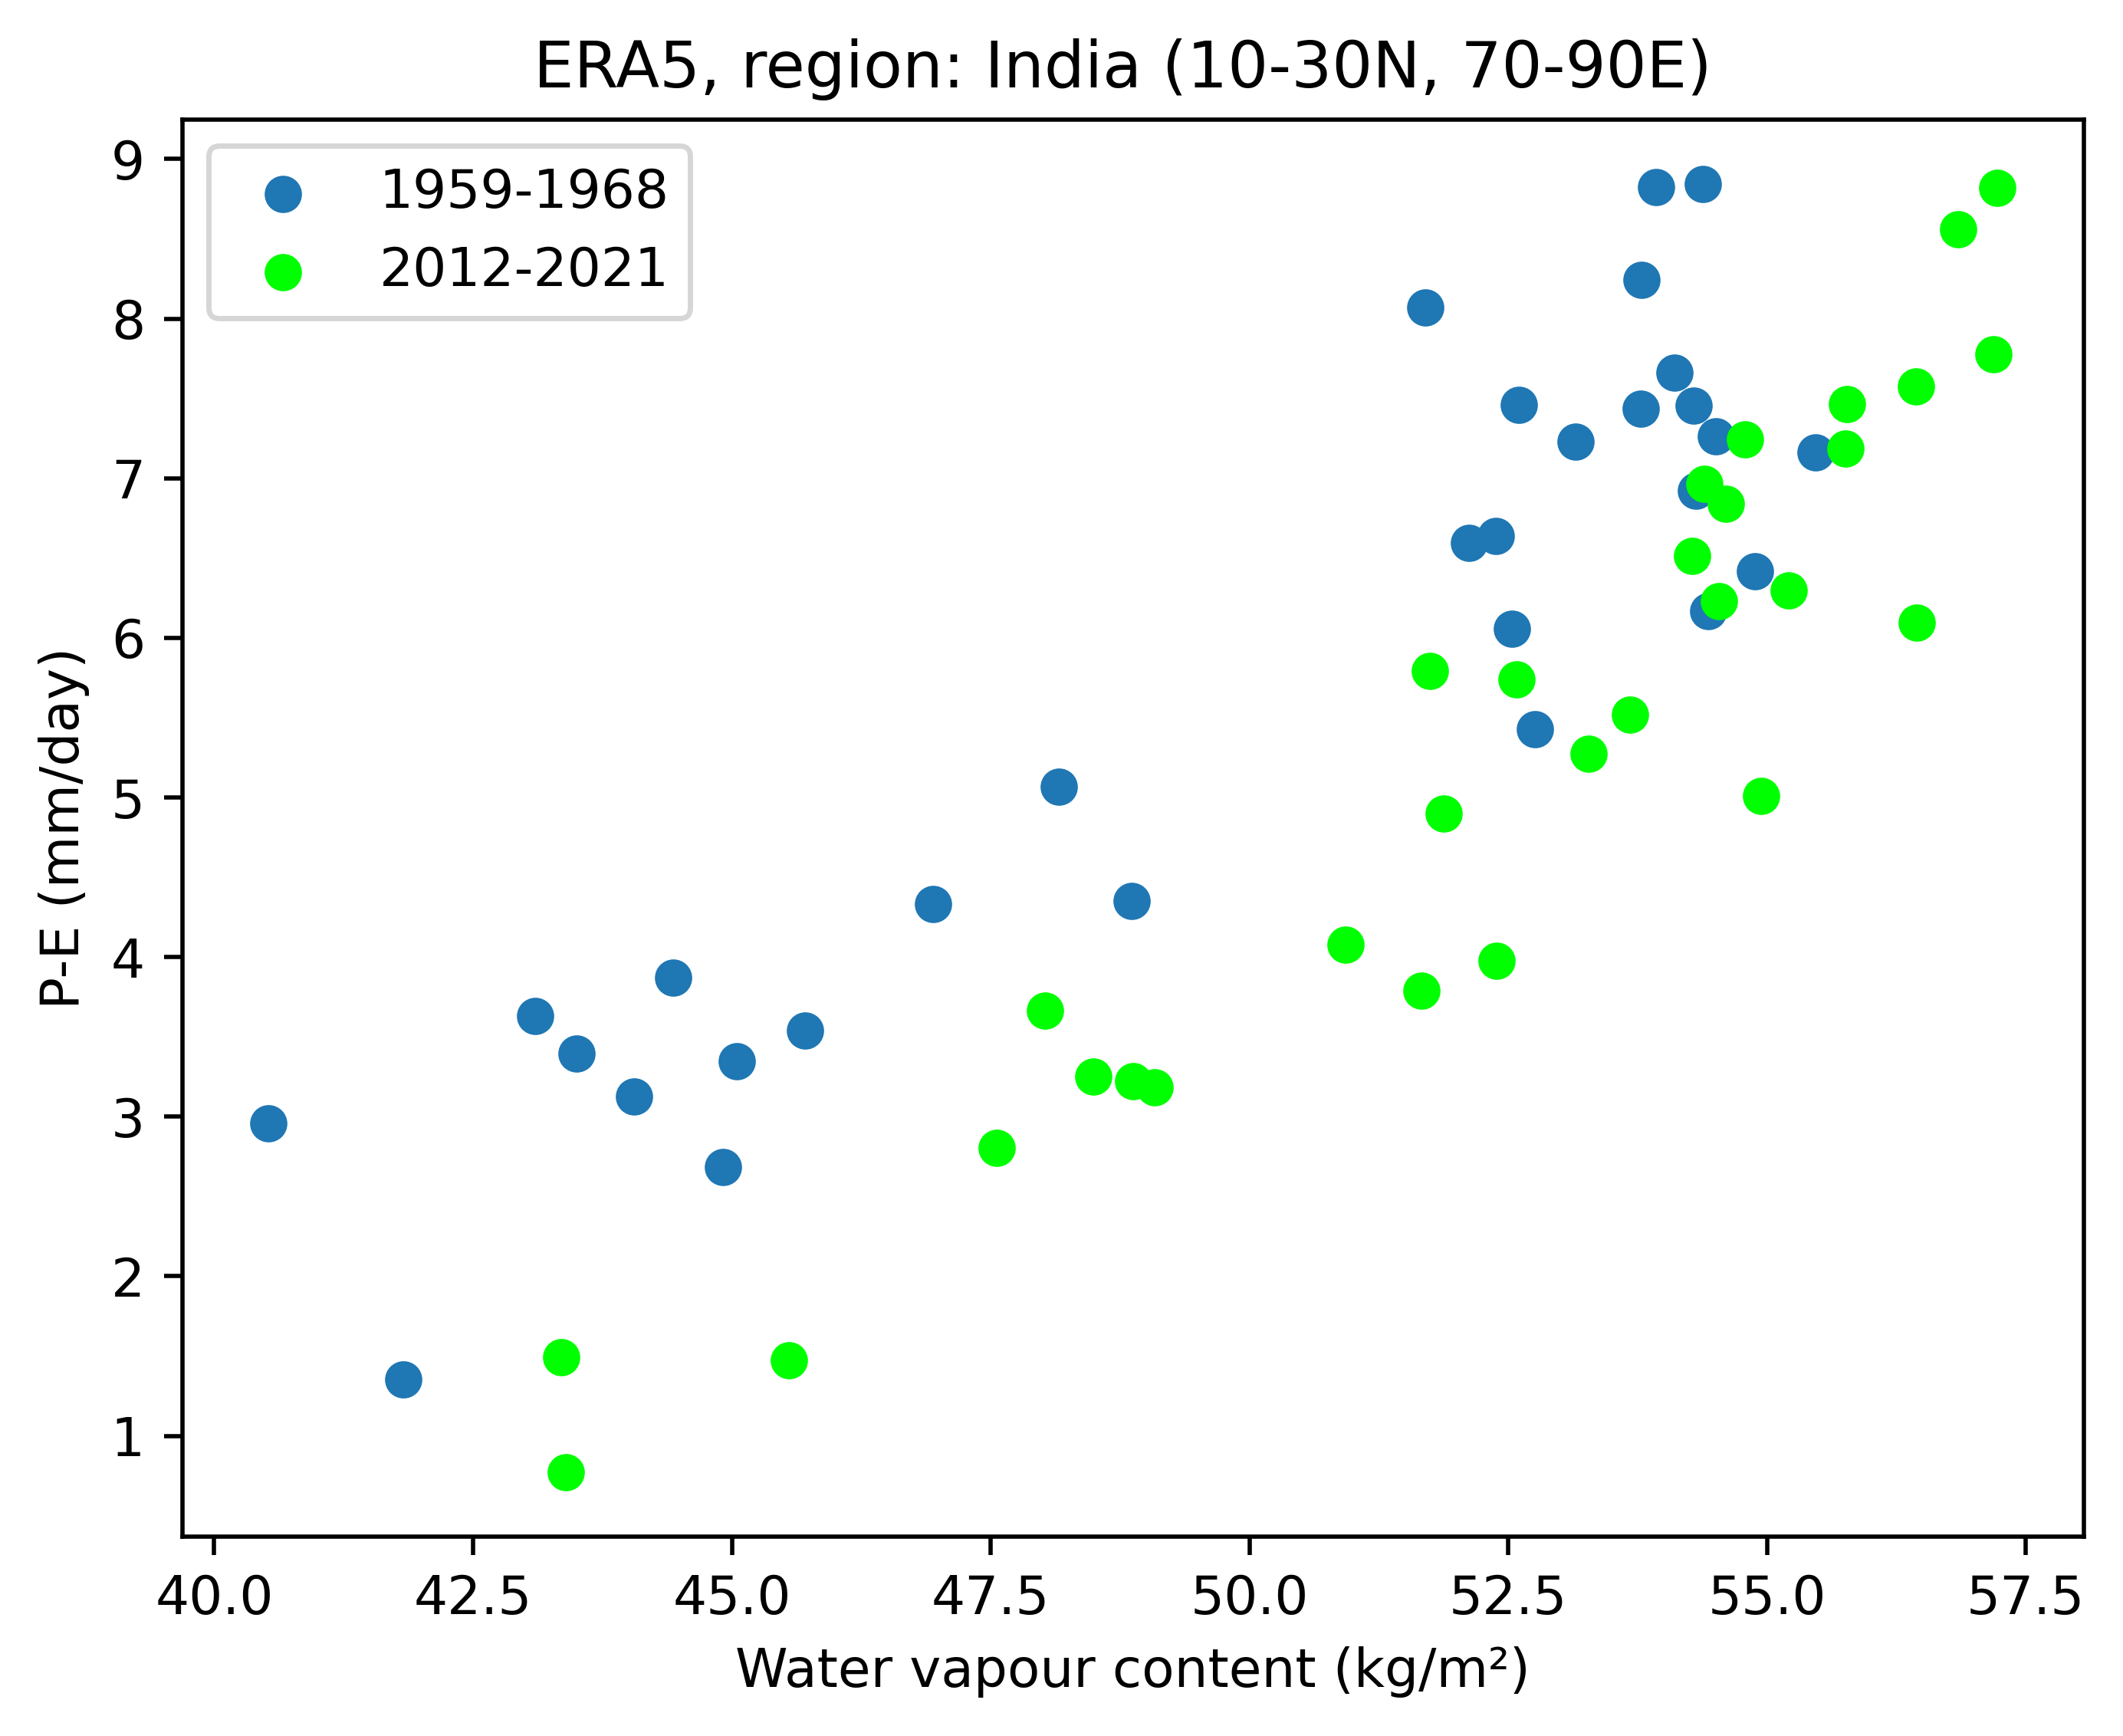

In [62]:
plt.scatter(Pwat1, Pr1/28.96, label=year1 + '-' + year2)
plt.scatter(Pwat2, Pr2/28.96, label=year3 + '-' + year4, c='lime')
plt.xlabel('Water vapour content (kg/m\u00b2)')
plt.ylabel('P-E (mm/day)')
plt.title('ERA5, region: '+ region + " ({}".format(abs(lat2)) + str1 +"{}N, {}-{}E) ".format(abs(lat1), abs(lon1), abs(lon2)))
#plt.title('Only months June-September')
plt.legend()
plt.show()

Text(0.5, 1.0, 'ERA5, region: India (10-30N, 70-90E) ')

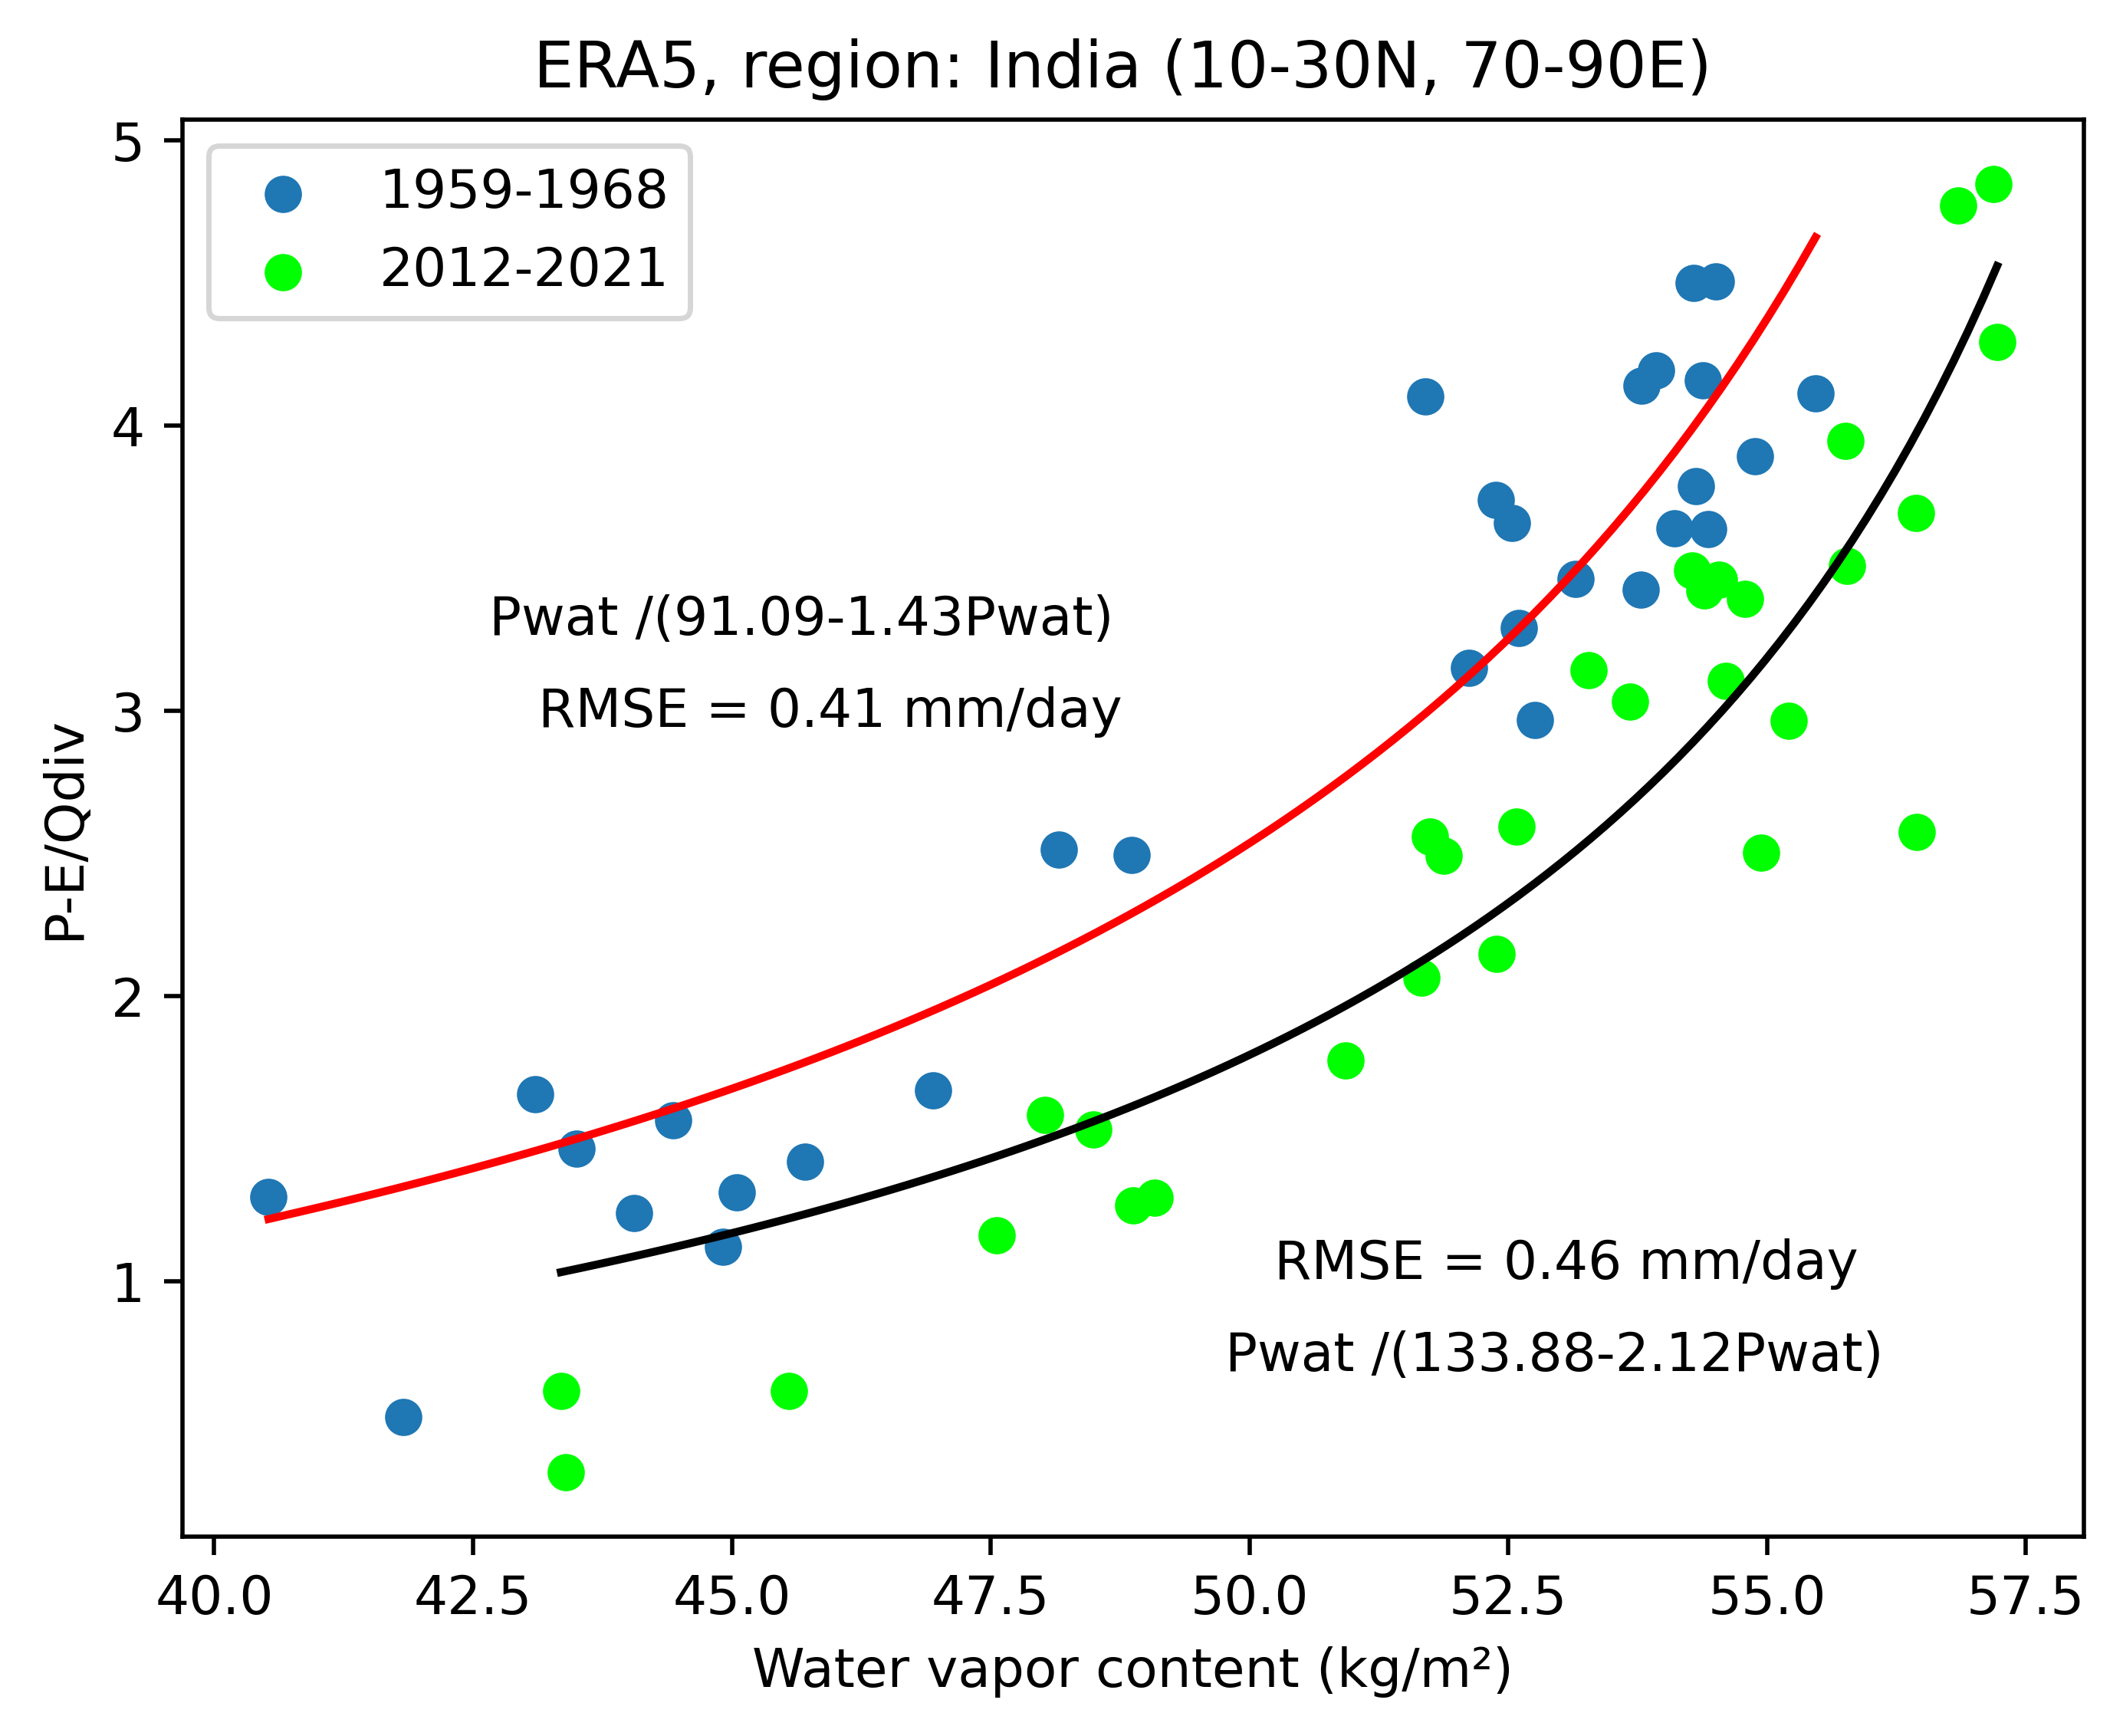

In [63]:
x1, y1 = Pwat1.values, ratio1.values
x2, y2 = Pwat2.values, ratio2.values

def objective(x, a, b):
    return x/(a-b*x)

p0 = [80, 1]

popt1, _ = curve_fit(objective, x1, y1, p0)
popt2, _ = curve_fit(objective, x2, y2, p0)
a1, b1 = popt1
a2, b2 = popt2

x_line1 = np.linspace(np.min(x1), np.max(x1), 100)
x_line2 = np.linspace(np.min(x2), np.max(x2), 100)
y_line1 = objective(x_line1, a1, b1)
y_line2 = objective(x_line2, a2, b2)

pred1 = objective(x1, a1, b1)
pred2 = objective(x2, a2, b2)

from sklearn.metrics import mean_squared_error
rmse1 = mean_squared_error(y1, pred1, squared=False)
rmse2 = mean_squared_error(y2, pred2, squared=False)

plt.scatter(Pwat1, ratio1, label=year1 + '-' + year2)
plt.scatter(Pwat2, ratio2, label=year3 + '-' + year4, c='lime')
plt.plot(x_line1, y_line1, c='r')
plt.plot(x_line2, y_line2, c='black')
plt.figtext(0.25, 0.6, 'Pwat /(%.2f-%.2fPwat)' % (a1, b1))
plt.figtext(0.55, 0.2, 'Pwat /(%.2f-%.2fPwat)' % (a2, b2))
plt.figtext(0.27, 0.55, 'RMSE = %.2f mm/day' % (rmse1))
plt.figtext(0.57, 0.25, 'RMSE = %.2f mm/day' % (rmse2))
plt.xlabel('Water vapor content (kg/m\u00b2)')
plt.ylabel('P-E/Qdiv')
plt.legend()
plt.title('ERA5, region: '+ region + " ({}".format(abs(lat2)) + str1 +"{}N, {}-{}E) ".format(abs(lat1), abs(lon1), abs(lon2)))

Text(0.5, 1.0, 'ERA5, region: India (10-30N, 70-90E) ')

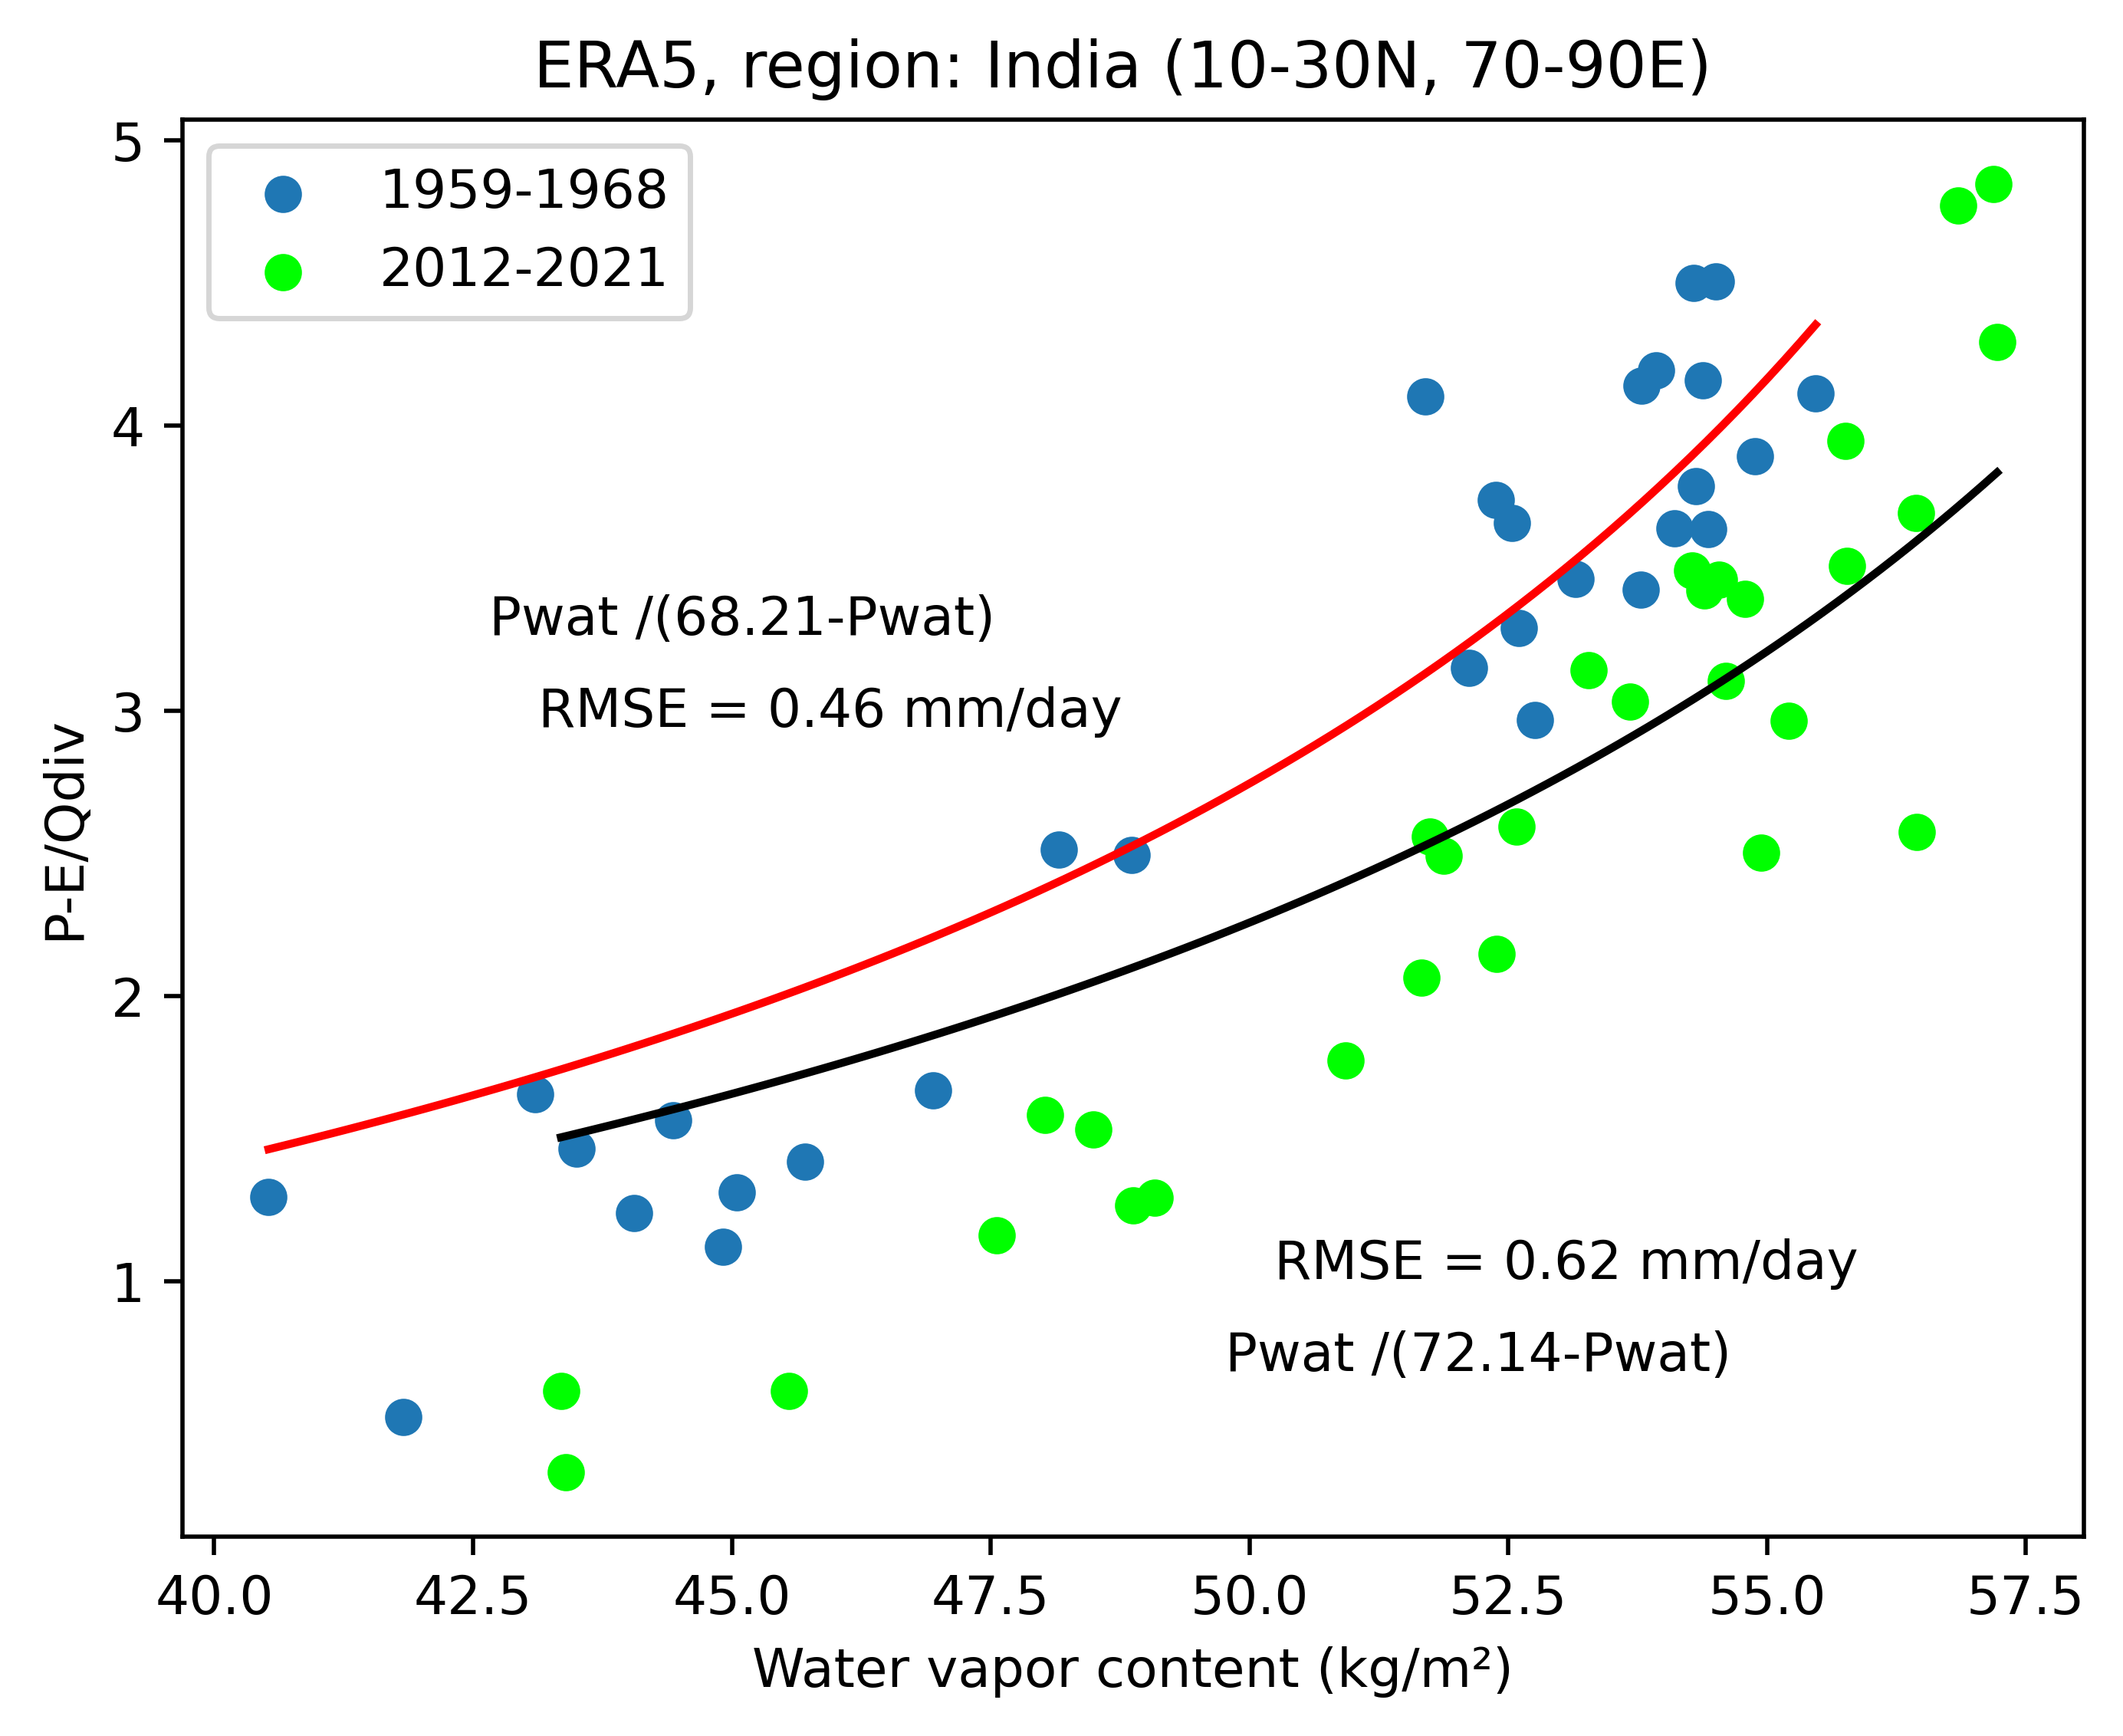

In [45]:
x1, y1 = Pwat1.values, ratio1.values
x2, y2 = Pwat2.values, ratio2.values

def objective(x, a):
    return x/(a-x)

p0 = [80]

popt1, _ = curve_fit(objective, x1, y1, p0)
popt2, _ = curve_fit(objective, x2, y2, p0)
c1 = popt1
c2 = popt2

x_line1 = np.linspace(np.min(x1), np.max(x1), 100)
x_line2 = np.linspace(np.min(x2), np.max(x2), 100)
y_line1 = objective(x_line1, c1)
y_line2 = objective(x_line2, c2)

pred1 = objective(x1, c1)
pred2 = objective(x2, c2)

from sklearn.metrics import mean_squared_error
rmse1 = mean_squared_error(y1, pred1, squared=False)
rmse2 = mean_squared_error(y2, pred2, squared=False)

plt.scatter(Pwat1, ratio1, label=year1 + '-' + year2)
plt.scatter(Pwat2, ratio2, label=year3 + '-' + year4, c='lime')
plt.plot(x_line1, y_line1, c='r')
plt.plot(x_line2, y_line2, c='black')
plt.figtext(0.25, 0.6, 'Pwat /(%.2f-Pwat)' % (c1))
plt.figtext(0.55, 0.2, 'Pwat /(%.2f-Pwat)' % (c2))
plt.figtext(0.27, 0.55, 'RMSE = %.2f mm/day' % (rmse1))
plt.figtext(0.57, 0.25, 'RMSE = %.2f mm/day' % (rmse2))
plt.xlabel('Water vapor content (kg/m\u00b2)')
plt.ylabel('P-E/Qdiv')
plt.legend()
plt.title('ERA5, region: '+ region + " ({}".format(abs(lat2)) + str1 +"{}N, {}-{}E) ".format(abs(lat1), abs(lon1), abs(lon2)))

Text(0.5, 1.0, 'JJAS')

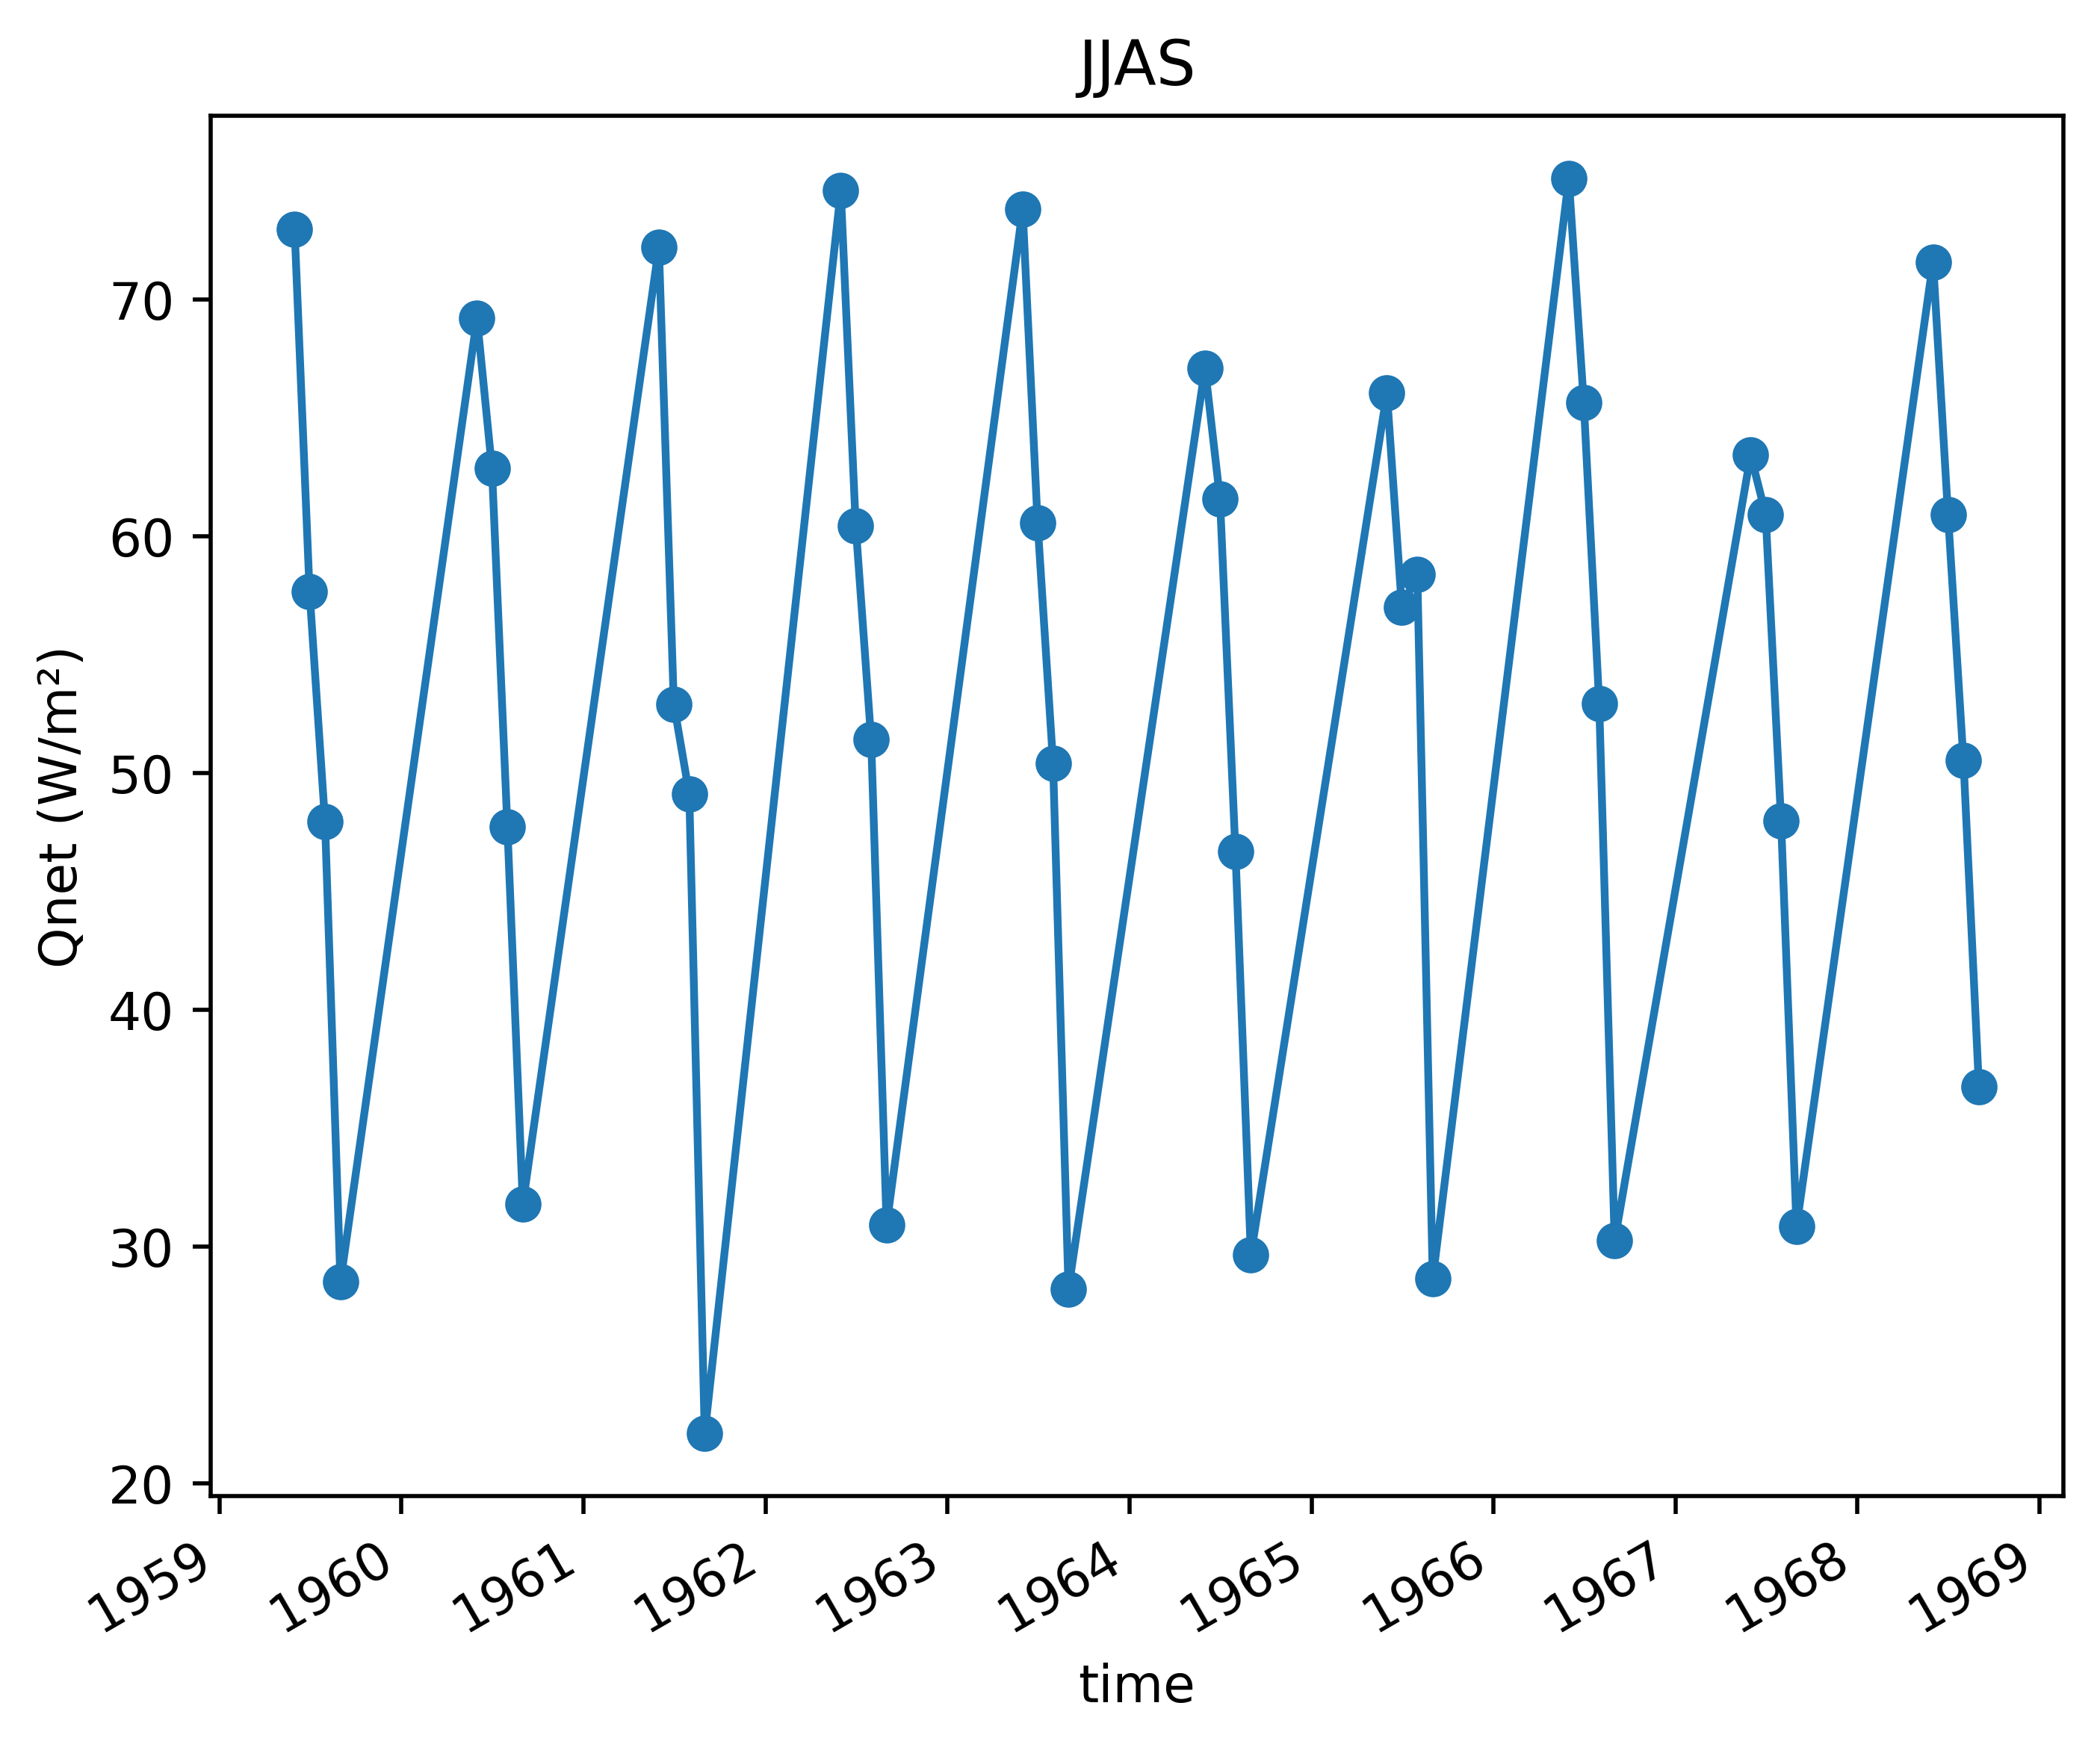

In [81]:
Qnet1.plot(marker='o')
plt.ylabel('Qnet (W/m\u00b2)')
plt.title('JJAS')

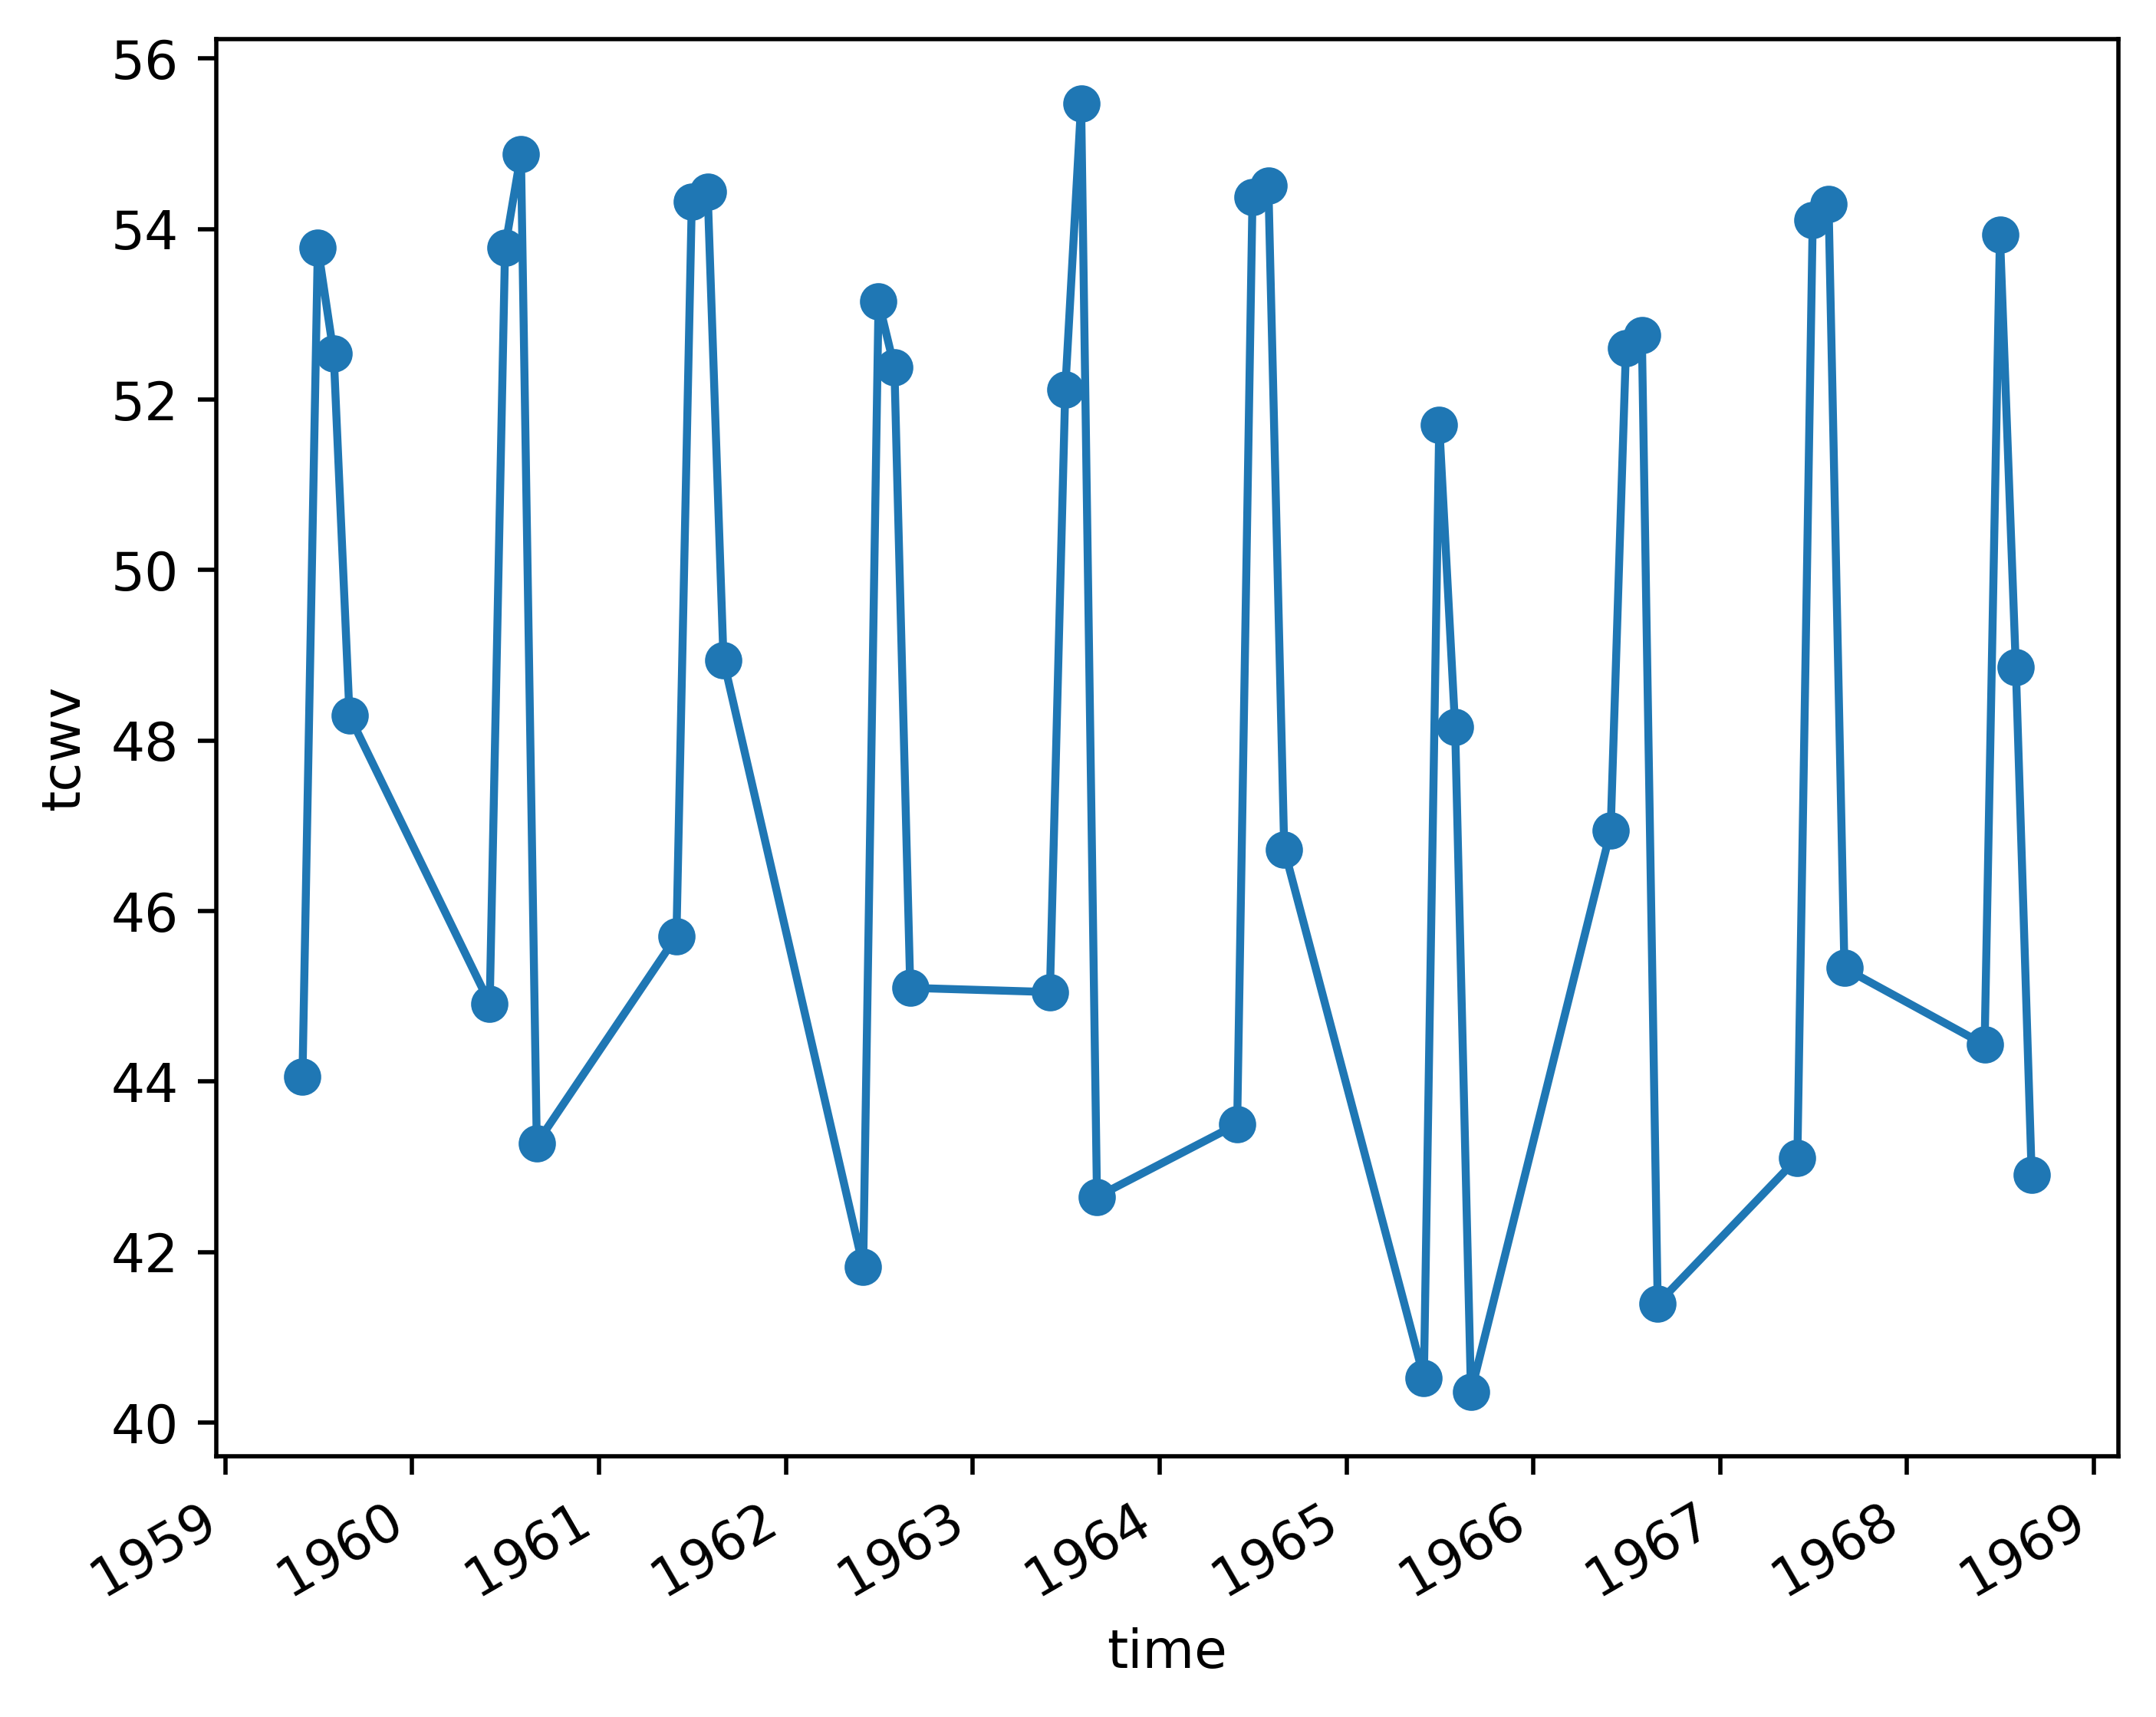

In [14]:
Pwat1.plot(marker='o')

Text(0.5, 1.0, 'JJA')

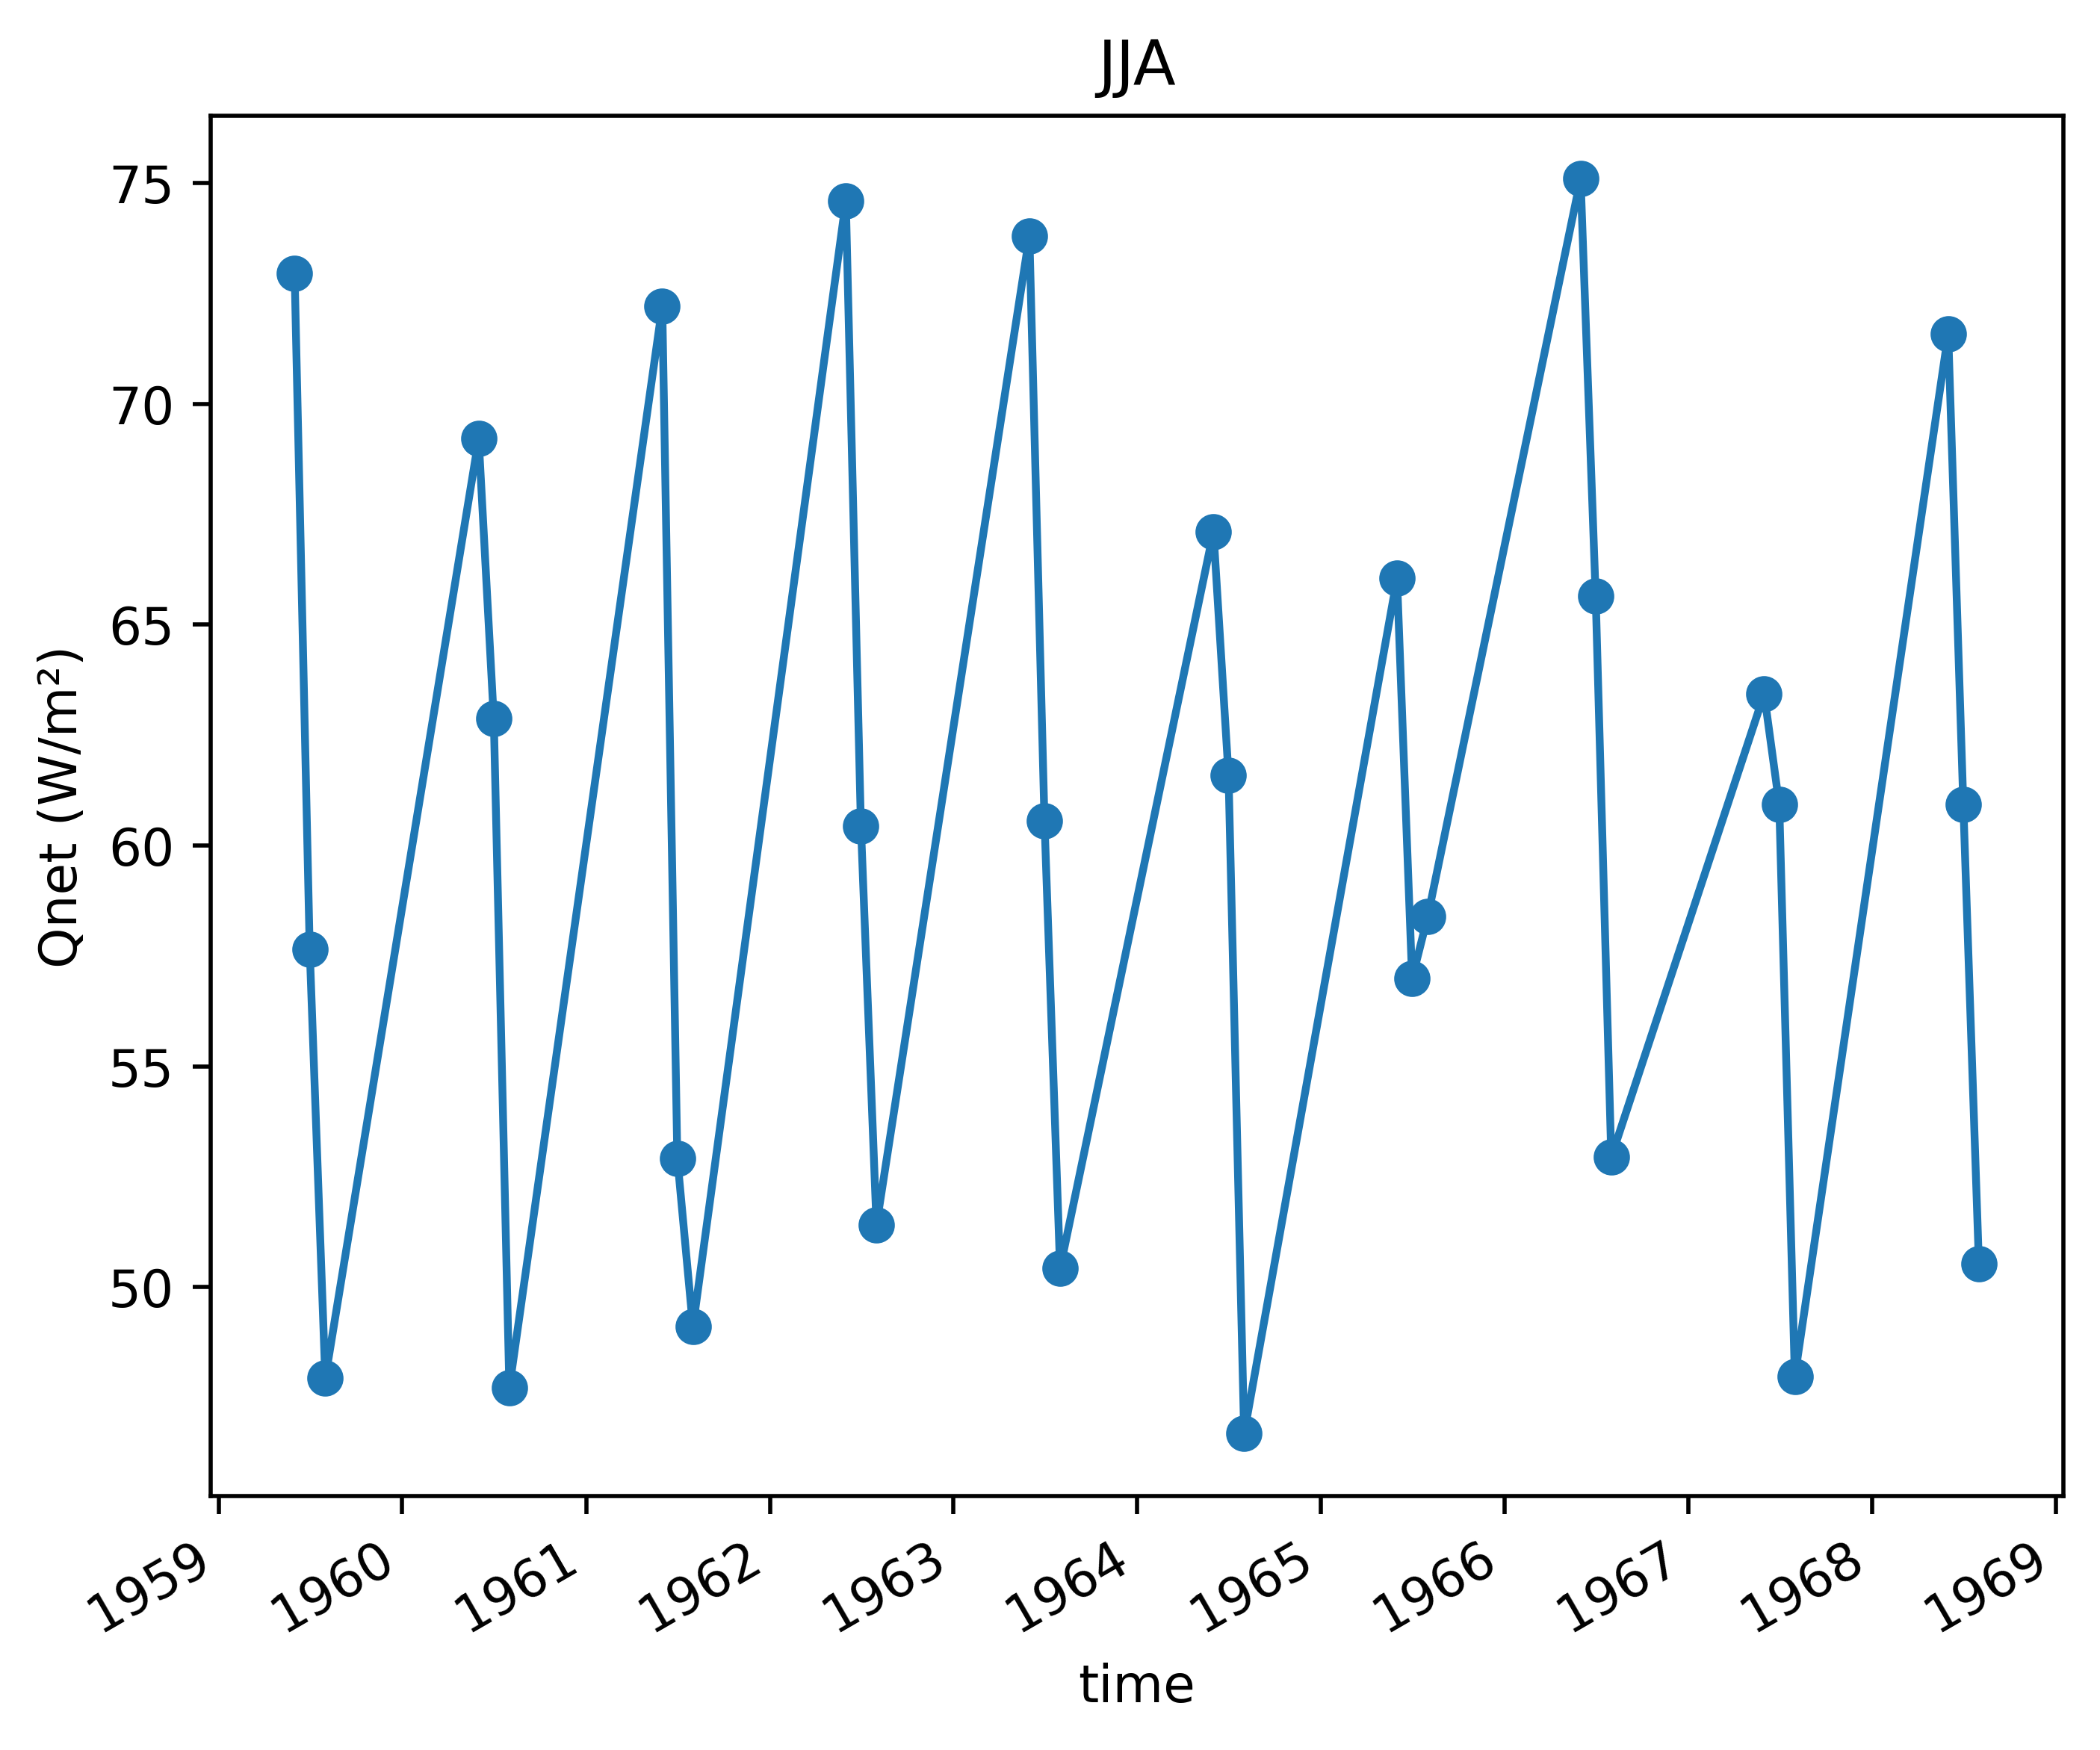

In [85]:
Qnet1.plot(marker='o')
plt.ylabel('Qnet (W/m\u00b2)')
plt.title('JJA')

In [99]:
grid2 = ds.sel(time=slice('2002', '2004'))
grid2 = grid2.where(mask>0).mean(dim=['latitude', 'longitude']).squeeze()

In [100]:
Qnet2 = grid2.mtnswrf + grid2.mtnlwrf

Text(0.5, 1.0, 'J-D')

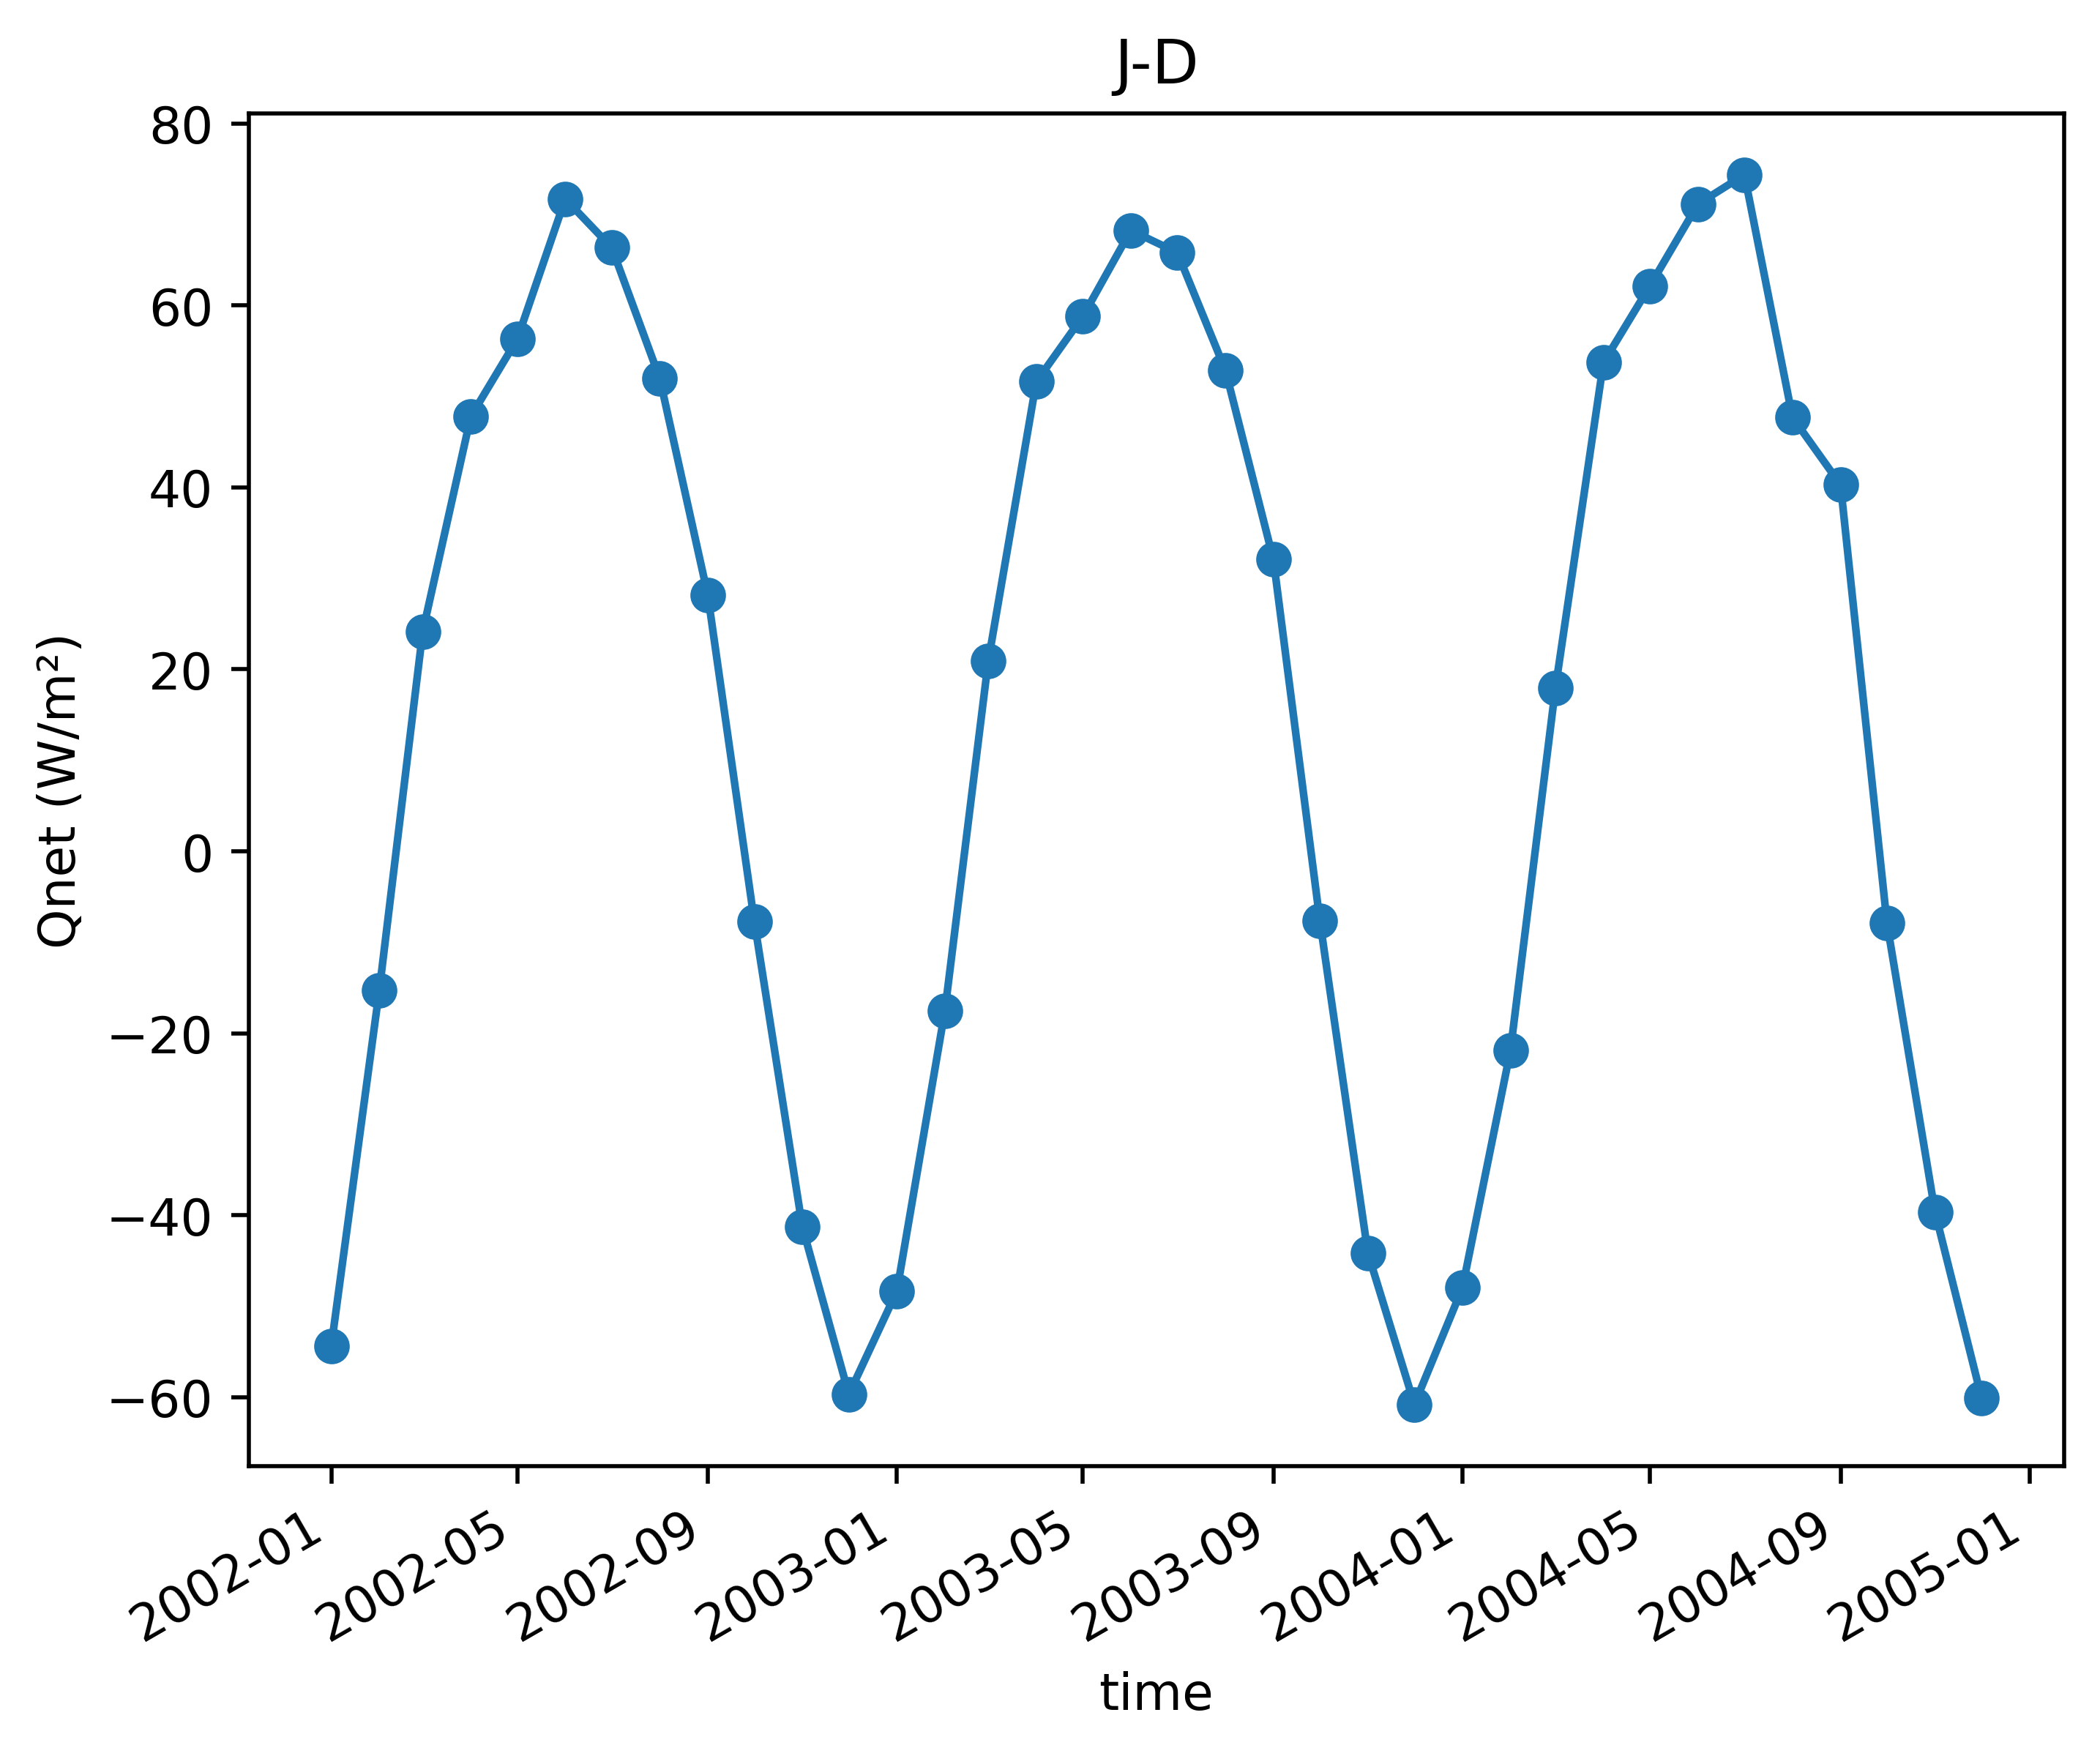

In [101]:
Qnet2.plot(marker='o')
plt.ylabel('Qnet (W/m\u00b2)')
plt.title('J-D')